# Base Length Correciotn
---
Author: Min Joh <br>
Contributor: Min Joh, Hyunji Cha, Surjith Kumaran <br>
Created: 2024-12-23 <br>
Occupation: SEED Lab, Department of Chemical and Material Engineering, University of Alberta <br>
Supervisor: Hyo-jick Choi <br>

# 1. Setups

## 1.1. Import packages

In [48]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

## 1.2. Configurations

In [49]:
class CFG:
    """
    Configuration class for the Base Length Correciton
    : adjusting the color inputs based on the background lightness
    """

    # ========== Input Data ==========
    INPUT_DATASET_FILE_NAME = os.path.join("..", "data", "tests", "BCA_unknown_sample_4.csv")

    # ========== Reference Data ===========
    RGB_CALIBRATION_FILE_NAME = os.path.join("..", "data", "calibration.txt")
    BASE_LENGTH_CORRECTION_FILE_NAME = os.path.join("..", "data", "base_length.csv")

    # ========== Output Data ==========
    OUTPUT_DATASET_FILE_NAME = os.path.join("..", "data", "tests", "BCA_unknown_sample_4_corrected.csv")
    SAVE_OUTPUT = True

    # ========== Figure Options ===========
    DISPLAY_FIGURE = True
    SAVE_FIGURE = False

In [50]:
# Define a function to save figure
def save_fig(fig, fig_name, dir_name=''):
    try:
        # Create /docs directory if doesn't exist
        if not dir_name == '' and not os.path.exists(dir_name):
            os.makedirs(dir_name)
            print(f"Document directory is created at: {dir_name}")

        # Save the figure
        fig_name = fig_name.lower().replace(" ", "_")
        if dir_name == '':
            fig_file = f"{fig_name}.png"
        else:
            fig_file = os.path.join(dir_name, f"{fig_name}.png")
        fig.savefig(fig_file, dpi=300)
        print(f"Figure saved at: {os.path.abspath(fig_file)}")

    except Exception as e:
        print("Saving figure error occurred: {e}")

In [51]:
print(f"Input File: {CFG.INPUT_DATASET_FILE_NAME}\nOutput File: {CFG.OUTPUT_DATASET_FILE_NAME}")

Input File: ..\data\tests\BCA_unknown_sample_4.csv
Output File: ..\data\tests\BCA_unknown_sample_4_corrected.csv


## 1.4. Load Data

### 1.4.1. Input Dataset

In [52]:
# Load input dataset
input_df = pd.read_csv(CFG.INPUT_DATASET_FILE_NAME)
print(f"Size of Input Data: {input_df.shape}\n")
print(input_df.head())

Size of Input Data: (60, 9)

  Label  concentration  Red_Frequency  Green_Frequency  Blue_Frequency  \
0  1-D1         27.137    17222.77386     12218.640720     14025.46187   
1  1-D2         21.348    15615.20850     10384.401570     12940.11302   
2  1-D3         23.882    16072.44909     10987.612250     13515.36953   
3  1-D4         22.754    13617.97394      8742.826951     11378.35390   
4  1-D5         22.191    13916.67012      9007.579191     11640.41152   

   Clear_Frequency         Red       Green        Blue  
0      20788.82024  139.261697  115.225831  151.833606  
1      31941.19535  117.234706   82.938699  132.495897  
2      19418.47619  124.827208   93.197281  142.564882  
3      31477.34422   87.457310   53.880864  102.136404  
4      31897.39950   91.729833   58.563872  107.083705  


### 1.4.2. RGB Calibration Data

In [53]:
# Define a function to load sensor calibration data
def load_calibration_data(calibration_data_path):
    # Check if the data file exists
    if not os.path.exists(calibration_data_path):
        print(f"No calibration data found at: {os.path.abspath(calibration_data_path)}")
        return None, None

    # Load the global_min and global_max data
    try:
        with open(calibration_data_path, 'r') as file:
            lines = file.readlines()
            global_min = [float(val) for val in lines[0].split(":")[1].strip()[1:-1].split(", ")]
            global_max = [float(val) for val in lines[1].split(":")[1].strip()[1:-1].split(", ")]
        print(f"Calibration data loaded from: {os.path.abspath(calibration_data_path)}")
    except Exception as e:
        print(f"Calibration data load error occurred: {e}")
        return None, None

    return global_min, global_max

In [54]:
# Set the minimum and maximum RGB conversion domain
global_min, global_max = load_calibration_data(CFG.RGB_CALIBRATION_FILE_NAME)
print(f"Global Min = {global_min}\nGlobal Max = {global_max}")

Calibration data loaded from: d:\johmi\UAlberta Research Projects\Color_Sensor\Programs\dev_0.1.2\data\calibration.txt
Global Min = [7732.000584094109, 5676.123202123859, 5978.362954574857, 14314.33181520495]
Global Max = [24874.066158777456, 20190.11600897794, 19428.380161543977, 31251.29160430175]


### 1.4.3. Base Length Correction Data

In [55]:
# Load base length correction data
blc_df = pd.read_csv(CFG.BASE_LENGTH_CORRECTION_FILE_NAME)
print(blc_df.head())

   Red_Frequency  Green_Frequency  Blue_Frequency  Clear_Frequency  \
0    25170.28286      20621.68811     19584.55214      31705.83103   
1    25108.68826      20670.45279     19579.05955      31713.89003   
2    24885.16705      20272.14887     19310.39994      31413.69885   
3    29224.10873      24000.90911     22654.53076      35188.90953   
4    29344.24354      24135.95569     22820.34428      34733.69585   

          Red  Green        Blue Well_Row  
0  255.000000  255.0  255.000000        A  
1  255.000000  255.0  255.000000        A  
2  252.976748  255.0  251.602587        A  
3  255.000000  255.0  255.000000        B  
4  255.000000  255.0  255.000000        B  


# 2. Set Base Length Correction Standard

In [56]:
# Add a new column for the sum of frequencies
blc_df['Frequency_Sum'] = blc_df[['Red_Frequency', 'Green_Frequency', 'Blue_Frequency']].sum(axis=1)

# Group by 'Well_Row' and calculate the mean and standard deviation of the sums
normalization_df = blc_df.groupby('Well_Row')['Frequency_Sum'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
normalization_df.rename(columns={'mean': 'Mean_Frequency_Sum', 'std': 'Std_Frequency_Sum'}, inplace=True)

# Calculate the brightest value
brightest_value = normalization_df['Mean_Frequency_Sum'].max()

# Create the normalization factor for each Well_Row
normalization_df['Normalization_Factor'] = normalization_df['Mean_Frequency_Sum'] / brightest_value

# Display the processed data
print(normalization_df)

  Well_Row  Mean_Frequency_Sum  Std_Frequency_Sum  Normalization_Factor
0        A        65067.479857         519.491643              0.835841
1        B        76088.358227         210.517754              0.977413
2        C        77846.682797         302.797284              1.000000
3        D        75873.606040         405.714480              0.974654
4        E        71794.878300         520.255347              0.922260
5        F        66255.148963         313.976613              0.851098
6        G        61264.519043         679.857523              0.786989
7        H        54979.853340         296.943926              0.706258


Figure saved at: d:\johmi\UAlberta Research Projects\Color_Sensor\Programs\dev_0.1.2\docs\sum_of_rgb_frequencies_for_each_row.png


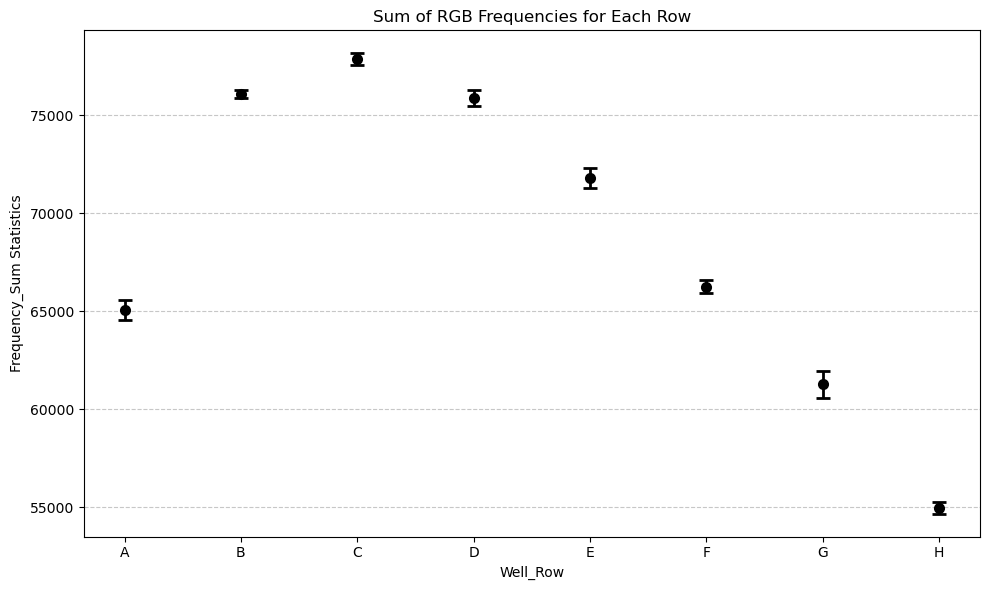

In [57]:
# Create an error bar plot without connected lines
fig1, ax1 = plt.subplots(figsize=(10, 6))  # Use plt.subplots() to get both Figure and Axes
figure_title = "Sum of RGB Frequencies for Each Row"

ax1.errorbar(
    normalization_df['Well_Row'], 
    normalization_df['Mean_Frequency_Sum'], 
    yerr=normalization_df['Std_Frequency_Sum'], 
    fmt='o', 
    capsize=5, 
    elinewidth=2, 
    markeredgewidth=2,
    color='black'
)

ax1.set_xlabel('Well_Row')  # Use set_xlabel for Axes
ax1.set_ylabel('Frequency_Sum Statistics')  # Use set_ylabel for Axes
ax1.set_title(figure_title)  # Use set_title for Axes
ax1.grid(axis='y', linestyle='--', alpha=0.7)
fig1.tight_layout()  # Use tight_layout() on the Figure

if CFG.DISPLAY_FIGURE == True:
    save_fig(fig1, figure_title)

if CFG.DISPLAY_FIGURE == True:
    plt.show()

# 3. Apply Base Length Correciton

In [58]:
# Copy from the original data
output_df = input_df.copy()
output_df.columns = output_df.columns.str.strip()

# Add a new column to extract the Well_Row from the Label (e.g., "1_D1" -> "D")
output_df['Well_Row'] = output_df['Label'].str.split('-').str[-1].str[0]

# Create a mapping of Well_Row to Normalization_Factor from normalization_df
normalization_mapping = normalization_df.set_index('Well_Row')['Normalization_Factor']

# Map the Normalization_Factor to output_df based on Well_Row
output_df['Normalization_Factor'] = output_df['Well_Row'].map(normalization_mapping)

# Normalize frequency columns by dividing by the corresponding Normalization_Factor
frequency_columns = ['Red_Frequency', 'Green_Frequency', 'Blue_Frequency']
for col in frequency_columns:
    output_df[col] = output_df[col] / output_df['Normalization_Factor']

# Map global min and max values to the corresponding columns
min_max_mapping = {
    'Red': (global_min[0], global_max[0]),
    'Green': (global_min[1], global_max[1]),
    'Blue': (global_min[2], global_max[2])
}

# Apply linear interpolation for each color channel
for color in ['Red', 'Green', 'Blue']:
    min_val, max_val = min_max_mapping[color]
    # Apply the formula to scale values between 0 and 255
    output_df[color] = ((output_df[f'{color}_Frequency'] - min_val) / (max_val - min_val)) * 255
    # Clip values to ensure they stay within the 0 to 255 range
    output_df[color] = output_df[color].clip(0, 255)

# Display the results
print(output_df.head())


  Label  concentration  Red_Frequency  Green_Frequency  Blue_Frequency  \
0  1-D1         27.137   17670.648379     12536.383836    14390.190980   
1  1-D2         21.348   16021.278628     10654.445693    13276.617867   
2  1-D3         23.882   16490.409661     11273.342736    13866.833799   
3  1-D4         22.754   13972.106414      8970.182280    11674.245538   
4  1-D5         22.191   14278.570124      9241.819345    11943.117910   

   Clear_Frequency         Red       Green        Blue Well_Row  \
0      20788.82024  147.844213  120.529649  159.480550        D   
1      31941.19535  123.308705   87.465403  138.368225        D   
2      19418.47619  130.287351   98.338962  149.558178        D   
3      31477.34422   92.825860   57.874155  107.988714        D   
4      31897.39950   97.384719   62.646615  113.086288        D   

   Normalization_Factor  
0              0.974654  
1              0.974654  
2              0.974654  
3              0.974654  
4              0.97465

In [59]:
if CFG.SAVE_OUTPUT == True:
    output_df.to_csv(CFG.OUTPUT_DATASET_FILE_NAME, index=False)